In [253]:
import pandas as pd
import numpy as np

In [275]:
precipitation_df=pd.read_csv(r"data\Cuba_Precipitation_with_Nodes (1) (2).csv")
adj_matrix=pd.read_csv(r"data\Adjacency_Matrix______0_80.csv", index_col=0)
precipitation_df["time"]=pd.to_datetime(precipitation_df["time"])
precipitation_df=precipitation_df.sort_values(by=["node", "time"])
precipitation_df.reset_index(drop=True,inplace=True)
nodes=precipitation_df["node"].values
missing_nodes=set(nodes)-set(adj_matrix.index)
precipitation_df["precipitation_diff"]=precipitation_df.groupby("node")["precipitation"].diff()
precip_diff_df=precipitation_df.dropna(subset=["precipitation_diff"])
# precip_values



### STEP 2

In [276]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization,Dropout

In [277]:
pivot_df = precipitation_df.pivot(index='time', columns='node', values='precipitation')

full_range = pd.date_range(start='1979-01', end='2023-12', freq='M')
pivot_df = pivot_df.reindex(full_range)
pivot_df=pivot_df.fillna(0)

node_id=1
neighbors=adj_matrix.loc[node_id]
linked_nodes=neighbors[neighbors==1].index.tolist()
print(f"Node {node_id} neighbors: {linked_nodes}")
def get_node_series(node_id,precipitation_df):
    return precipitation_df[precipitation_df["node"]==node_id][["time","precipitation_diff"]].reset_index(drop=True)
mode_series=get_node_series(node_id,precipitation_df)
linked_nodes = [int(nb) for nb in linked_nodes]
all_series = [pivot_df[node_id].values]

for nb in linked_nodes:
    all_series.append(pivot_df[nb].values)

X=np.stack(all_series,axis=1)
print(X.shape)
def create_sequences(data,time_index,window_size=90):
    X,y,times=[],[],[]
    for i in range(len(data)-window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size,0])
        times.append(time_index[i+window_size])
    return np.array(X),np.array(y),np.array(times)

x_seq,y_seq,t_seq=create_sequences(X,pivot_df.index)
print(x_seq.shape,y_seq.shape)
num_features=x_seq.shape[2]



Node 1 neighbors: ['2', '11']
(539, 3)
(449, 90, 3) (449,)


C:\Users\gacha\AppData\Local\Temp\ipykernel_11244\612641064.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  full_range = pd.date_range(start='1979-01', end='2023-12', freq='M')


In [ ]:
model=Sequential([
    LSTM(64,input_shape=(30,num_features),return_sequences=False),
    Dense(32,activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam",loss='mse')
model.summary()

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

In [289]:
train_mask = (t_seq >= pd.to_datetime("1979-01-01")) & (t_seq <= pd.to_datetime("2014-12-31"))
test_mask  = (t_seq >= pd.to_datetime("2015-01-01")) & (t_seq <= pd.to_datetime("2023-12-31"))

X_train, y_train = x_seq[train_mask], y_seq[train_mask]
X_test, y_test   = x_seq[test_mask],  y_seq[test_mask]
history=model.fit(X_train,y_train,
                  validation_data=(X_test,y_test),
                  epochs=50,
                  batch_size=64,
                  verbose=1
                  )




Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 111.7409 - val_loss: 46.1756
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 105.7882 - val_loss: 43.3696
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 99.6314 - val_loss: 41.9996
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 97.0974 - val_loss: 44.1217
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 96.8177 - val_loss: 45.1049
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 95.8989 - val_loss: 42.8497
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 95.0454 - val_loss: 41.9638
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 94.4654 - val_loss: 41.9919
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 94.1199 - val_loss: 41.8698
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 93.7166 - val_loss: 42.0610
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 93.2262 - val_loss: 42.0682
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 92.

In [290]:
loss = model.evaluate(X_test, y_test)
print("Test MSE:", loss)

y_pred = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 45.9503
Test MSE: 45.95027160644531
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


In [291]:
aligned_series = pivot_df[node_id].reindex(t_seq).values

last_value = aligned_series[train_mask][-1]
y_pred_inverse=[]
for diff in y_pred.flatten():
    next_value=last_value+diff
    y_pred_inverse.append(next_value)
    last_value=next_value

y_pred_inverse=np.array(y_pred_inverse)


In [292]:
y_test_inverse=[]
last_value=aligned_series[train_mask][-1]
for diff in y_test.flatten():
    nect_value=last_value+diff
    y_test_inverse.append(next_value)
    last_value=next_value
y_test_inverse=np.array(y_test_inverse)

In [293]:
results_df=pd.DataFrame({
    "date":t_seq[test_mask],
    "node":node_id,
    "actual":y_test_inverse,
    "forecast":y_pred_inverse
})
results_df.to_csv("forecasts_node_{node_id}.csv",index=False)
print("Saved results for Node", node_id)

Saved results for Node 1


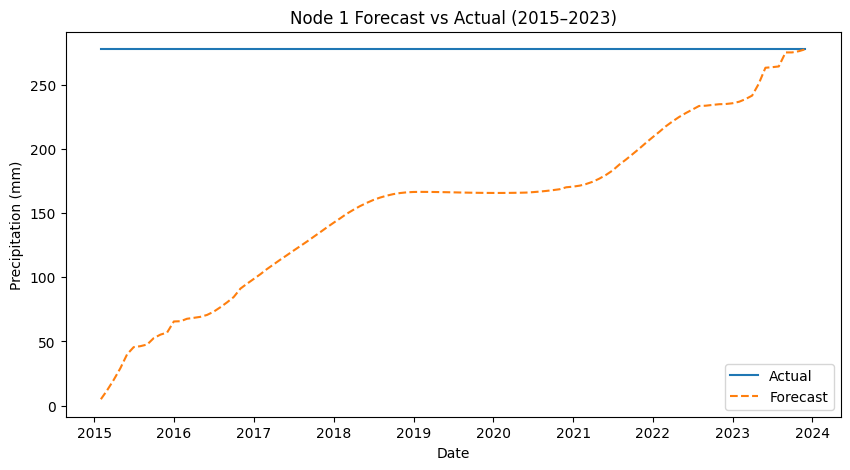

In [294]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(t_seq[test_mask], y_test_inverse, label="Actual")
plt.plot(t_seq[test_mask], y_pred_inverse, label="Forecast", linestyle="dashed")
plt.title(f"Node {node_id} Forecast vs Actual (2015–2023)")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.legend()
plt.show()